In [1]:
import matplotlib.pyplot as plt
import os
import torch
from typing import List
import pandas as pd

import nnts
import nnts.data
import nnts.experiments
import nnts.models
import nnts.torch.data.preprocessing as preprocessing
import nnts.torch.models
import nnts.torch.models.trainers as trainers
import nnts.metrics
import nnts.torch.data
import nnts.torch.data.datasets
import nnts.loggers
import covs 
import nnts.pandas
import nnts


%load_ext autoreload
%autoreload 2

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [3]:
data_path = "data"
model_name = "base-future-covariate-lstm"
base_model_name = "base-lstm"
dataset_name = "hospital"
results_path = "ablation-results"
metadata_path = os.path.join(data_path, f"{base_model_name}-monash.json")
metadata = nnts.data.metadata.load(dataset_name, path=metadata_path)
datafile_path = os.path.join(data_path, metadata.filename)
PATH = os.path.join(results_path, model_name, metadata.dataset)

df_orig, *_ = nnts.pandas.read_tsf(datafile_path)
params = nnts.models.Hyperparams()
splitter = nnts.pandas.LastHorizonSplitter()

nnts.loggers.makedirs_if_not_exists(PATH)

In [4]:
scenario_list: List[nnts.experiments.Scenario] = []

# Add the baseline scenarios
for seed in [42, 43, 44, 45, 46]:
    scenario_list.append(
        nnts.experiments.Scenario(metadata.prediction_length, conts=['month', 'unix_timestamp'], seed=seed)
    )

In [5]:
df_orig['month'] = df_orig['ds'].dt.month

In [6]:
class MaxMinScaler(nnts.data.preprocessing.Transformation):
    def __init__(self, max=None, min=None):
        self.max = max
        self.min = min

    def fit(self, data: pd.DataFrame, cols=None):
        numeric_data = data.select_dtypes(include=["number"])if cols is None else data[cols]
        self.max = numeric_data.max()
        self.min = numeric_data.min()
        return self

    def transform(self, data: pd.DataFrame, cols=None):
        numeric_data = data.select_dtypes(include=["number"]).columns if cols is None else data[cols]
        numeric_cols = numeric_data.columns
        data[numeric_cols] = (numeric_data - self.min) / (self.max - self.min)
        return data

    def inverse_transform(self, data: pd.DataFrame, cols=None):
        numeric_data = data.select_dtypes(include=["number"]) if cols is None else data[cols]
        numeric_cols = numeric_data.columns
        data[numeric_cols] = (
            numeric_data * (self.max - self.min) + self.min
        )
        return data

In [7]:
df_orig["unix_timestamp"] = (
    df_orig["ds"] - pd.Timestamp("1970-01-01")
) // pd.Timedelta("1s")

In [8]:
max_min_scaler = MaxMinScaler()
max_min_scaler.fit(df_orig, ["month", "unix_timestamp"])
df_orig = max_min_scaler.transform(df_orig, ["month", "unix_timestamp"])

In [9]:
for scenario in scenario_list[:1]:
    nnts.torch.data.datasets.seed_everything(scenario.seed)
    df = df_orig.copy()
    split_data = splitter.split(df, metadata)
    trn_dl, val_dl, test_dl = nnts.data.map_to_dataloaders(
        split_data,
        metadata,
        scenario,
        params,
        nnts.torch.data.TorchTimeseriesDataLoaderFactory(),
    )
    logger = nnts.loggers.LocalFileRun(
        project=f"{model_name}-{metadata.dataset}",
        name=scenario.name,
        config={
            **params.__dict__,
            **metadata.__dict__,
            **scenario.__dict__,
        },
        path=PATH,
    )
    net = covs.model_factory(model_name, params, scenario, metadata)
    trner = trainers.TorchEpochTrainer(
        nnts.models.TrainerState(), 
        net, 
        params, 
        metadata, 
        os.path.join(PATH, f"{scenario.name}.pt"),
    )
    logger.configure(trner.events)

    evaluator = trner.train(trn_dl, val_dl)
    y_hat, y = evaluator.evaluate(
        test_dl, scenario.prediction_length, metadata.context_length
    )
    test_metrics = nnts.metrics.calc_metrics(
        y, y_hat, metadata.freq, metadata.seasonality
    )
    logger.log(test_metrics)
    logger.finish()

TypeError: BaseLSTM.__init__() got an unexpected keyword argument 'known_future_covariates'

In [46]:
csv_aggregator = covs.CSVFileAggregator(PATH, "results")
results = csv_aggregator()

In [47]:
results = pd.read_csv(f"{PATH}/results.csv")
results

,input_dim,hidden_dim,n_layers,dropout,output_dim,batch_size,lr,epochs,patience,rnn_type,...,train_loss,valid_loss,mse,mae,mape,smape,abs_error,mase,rmse,run_time
0,1,40,2,0.1,1,128,0.001,100,10,lstm,...,0.264421,0.487326,3.619453,1.106229,inf,0.123178,7628.553711,0.265388,1.446995,303.968785
1,1,40,2,0.1,1,128,0.001,100,10,lstm,...,0.275766,0.760307,3.592184,1.119706,inf,0.124600,7721.490234,0.268621,1.446816,254.276808
2,1,40,2,0.1,1,128,0.001,100,10,lstm,...,0.276899,0.597820,3.619070,1.131404,inf,0.125999,7802.159668,0.271428,1.451579,271.308706
3,1,40,2,0.1,1,128,0.001,100,10,lstm,...,0.278154,0.778354,3.658419,1.194270,inf,0.133003,8235.683594,0.286510,1.482001,282.181325
4,1,40,2,0.1,1,128,0.001,100,10,lstm,...,0.289998,1.203597,3.875980,1.123761,inf,0.125236,7749.458496,0.269594,1.498043,236.122832


/Users/garethdavies/Development/workspaces/nnts/projects/rnn-covariates/covs.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group["y_hat"][-prediction_length:] = y_hat[i].squeeze()
/Users/garethdavies/Development/workspaces/nnts/projects/rnn-covariates/covs.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group["y_hat"][-prediction_length:] = y_hat[i].squeeze()
/Users/garethdavies/Development/workspaces/nnts/projects/rnn-covariates/covs.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

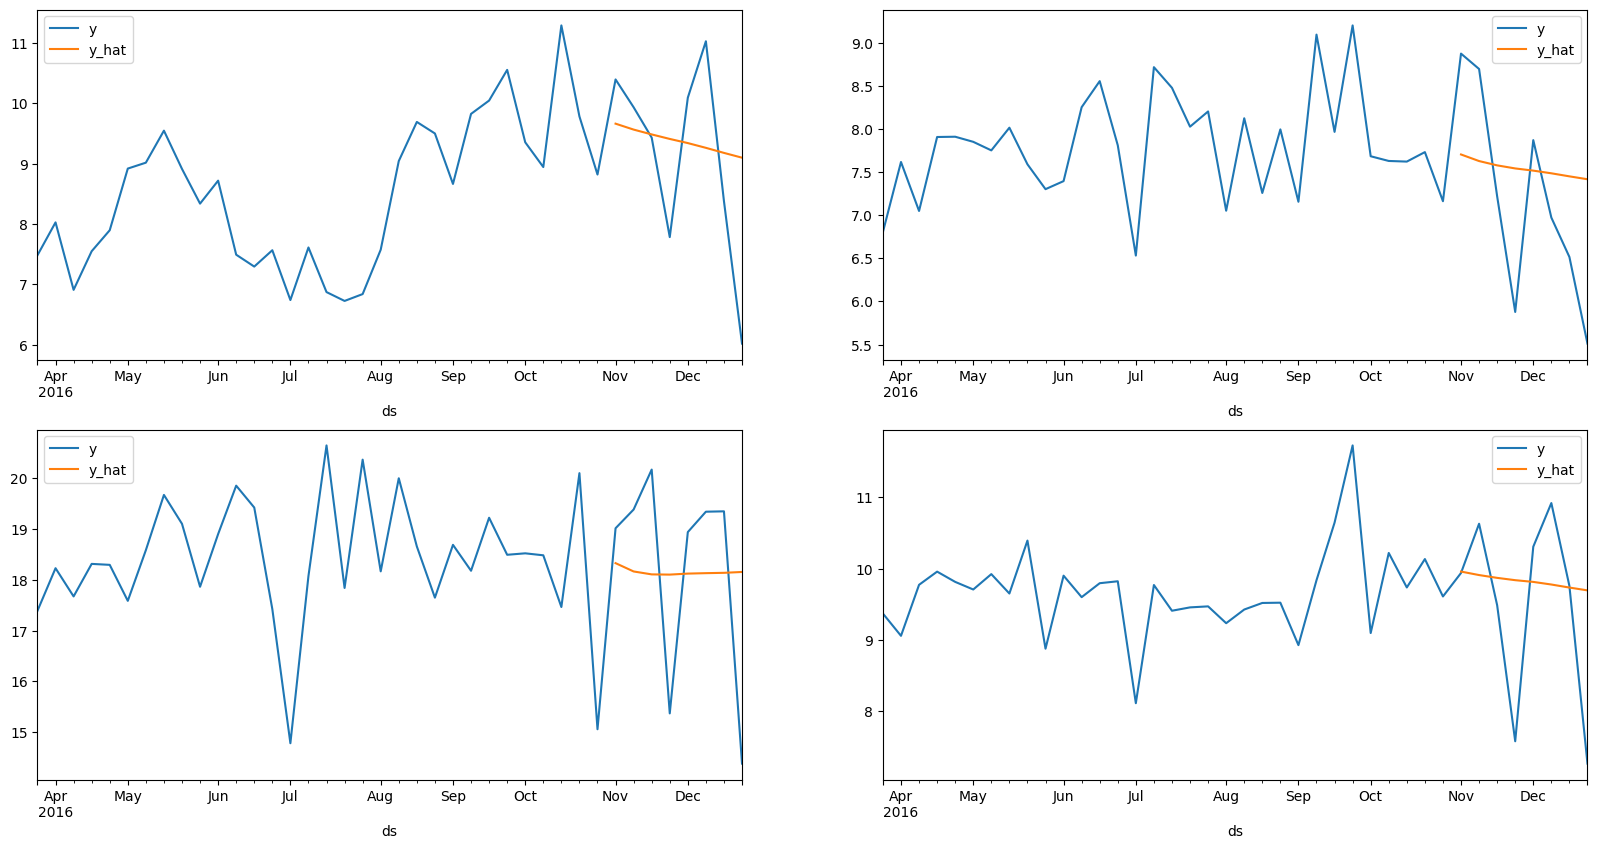

In [48]:
df_list = covs.add_y_hat(df, y_hat, scenario.prediction_length)
sample_preds = covs.plot(df_list, scenario.prediction_length)

In [49]:
univariate_results = results.loc[
    (results["prediction_length"] == metadata.prediction_length),
    ["smape", "mape", "rmse", "mae"],
]

univariate_results.mean(), univariate_results.std(), univariate_results.count()

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


(smape    0.126403
 mape          inf
 rmse     1.465087
 mae      1.135074
 dtype: float64,
 smape    0.003832
 mape          NaN
 rmse     0.023536
 mae      0.034329
 dtype: float64,
 smape    5
 mape     5
 rmse     5
 mae      5
 dtype: int64)

In [ ]:
cols = ["dataset", "error", "pearson", "covariates", "prediction_length", "smape"]

In [ ]:
results.loc[
    (results["covariates"] > 0)
    & (results["error"].isin([0.000000, 0.4714285714285714, 1.65])),
    cols,
].sort_values(by=['covariates', 'error'])

In [ ]:
sorted(results["error"].unique().tolist())

In [ ]:
import numpy as np
np.linspace(0, 0.6, 8).tolist()